In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [71]:
def load_dataset():
    df = pd.read_csv('c:/workspace/dillon.csv')
    df['li'] = pd.read_csv('c:/workspace/li.csv')

    # Remove data with NaN values
    df = df.dropna()

    # Separate the datasets
    X = df.drop(['date', 'hour', 'li'], axis=1)
    Y = df['li'].values
    
    # Scale the X dataset
    ss = StandardScaler() 
    X = ss.fit_transform(X)
    with open('c:/workspace/li_std_scaler.skl', 'wb') as f:
        pickle.dump(ss, f)

    # Select the best 50 features
    skb = SelectKBest(mutual_info_regression, k=50)
    X = skb.fit_transform(X, Y)
    with open('c:/workspace/li_k_best.skl', 'wb') as f:
        pickle.dump(skb, f)
   
    return train_test_split(X, Y, test_size=0.2)

In [72]:
x_train, x_test, y_train, y_test = load_dataset()

In [73]:
_, D =x_train.shape
K = 1

print(f"D: {D}, K: {K}")

D: 50, K: 1


In [74]:
model = torch.nn.Sequential()

model.add_module("dense1", torch.nn.Linear(D, 7))
model.add_module("tanh1", torch.nn.Tanh())
model.add_module("dense2", torch.nn.Linear(7, K))

In [75]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [76]:
def train(model, loss, optimizer, inputs, labels):
    optimizer.zero_grad()

    logits = model.forward(inputs)
    output = loss.forward(logits, labels)
    output.backward()
    optimizer.step()

    return output.item()

def predict(model, inputs):
    logits = model.forward(inputs)
    return logits.data.numpy()

def make_graph(y_test, y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.title.set_text('Interesting Region')
    ax1.scatter(y_test, y_pred)
    ax1.plot((-14, 50), (-14, 50), c='k')
    ax1.set_xlabel('actual')
    ax1.set_ylabel('prediction')
    ax1.set_ylim(-14, 6)
    ax1.set_xlim(-14, 6)

    ax2.title.set_text('Full Region')
    ax2.scatter(y_test, y_pred)
    ax2.plot((-14, 50), (-14, 50), c='k')
    ax2.set_xlabel('actual')
    ax2.set_ylabel('prediction')

    plt.show()

In [77]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()

epochs = 200
batch_size = 32
n_batches = x_train.size()[0] // batch_size
costs = []
test_accuracies = []

In [78]:
for i in range(epochs):
    cost = 0

    for j in range(n_batches):
        x_batch = x_train[j * batch_size:(j+1) * batch_size]
        y_batch = y_train[j * batch_size:(j+1) * batch_size].view(-1, 1)
        cost += train(model, loss, optimizer, x_batch, y_batch)

    y_pred = predict(model, x_test)
    acc = r2_score(y_pred, y_test)

    print(f"Epoch: {i}, cost: {cost / n_batches:.4f}, acc: {acc:.3f}")

    costs.append(cost / n_batches)
    test_accuracies.append(acc)

Epoch: 0, cost: 163.5429, acc: -12.494
Epoch: 1, cost: 89.8960, acc: -2.075
Epoch: 2, cost: 51.9472, acc: -0.122
Epoch: 3, cost: 34.1044, acc: 0.428
Epoch: 4, cost: 23.5198, acc: 0.667
Epoch: 5, cost: 16.6333, acc: 0.795
Epoch: 6, cost: 11.9427, acc: 0.867
Epoch: 7, cost: 8.6559, acc: 0.910
Epoch: 8, cost: 6.2974, acc: 0.938
Epoch: 9, cost: 4.6518, acc: 0.956
Epoch: 10, cost: 3.5215, acc: 0.968
Epoch: 11, cost: 2.7397, acc: 0.975
Epoch: 12, cost: 2.1844, acc: 0.980
Epoch: 13, cost: 1.7853, acc: 0.984
Epoch: 14, cost: 1.5056, acc: 0.986
Epoch: 15, cost: 1.3105, acc: 0.988
Epoch: 16, cost: 1.1727, acc: 0.989
Epoch: 17, cost: 1.0739, acc: 0.990
Epoch: 18, cost: 1.0018, acc: 0.991
Epoch: 19, cost: 0.9484, acc: 0.991
Epoch: 20, cost: 0.9079, acc: 0.991
Epoch: 21, cost: 0.8768, acc: 0.992
Epoch: 22, cost: 0.8523, acc: 0.992
Epoch: 23, cost: 0.8326, acc: 0.992
Epoch: 24, cost: 0.8166, acc: 0.992
Epoch: 25, cost: 0.8033, acc: 0.992
Epoch: 26, cost: 0.7921, acc: 0.992
Epoch: 27, cost: 0.7827, a

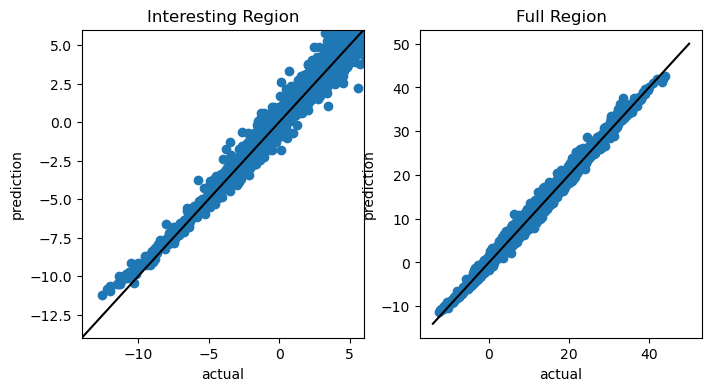

In [79]:
make_graph(y_test, y_pred)

In [80]:
torch.save(model.state_dict(), 'c:/workspace/li_fnn.pt')